# Experiment 3: Response Pattern Analysis

**Goal:** Analyze how system prompts change response PATTERNS (not just distributions).

**Setup:**
- Fixed test prompts
- Generate actual responses under different system prompts
- Analyze: length, structure, confidence markers, hedging

**Key Questions:**
- Do verbose system prompts produce verbose responses?
- Do cautious prompts increase hedging language?
- How do personas change response style?

In [3]:
# Setup path for imports
import sys
import os

# Handle both local and Colab environments
if 'google.colab' in sys.modules:
    # In Colab - go to repo root
    repo_root = '/content/LLM-Instruction-Understanding'
    if os.path.exists(repo_root):
        os.chdir(repo_root)
        if repo_root not in sys.path:
            sys.path.insert(0, repo_root)
else:
    # Local - add parent directory
    parent = os.path.abspath('..')
    if parent not in sys.path:
        sys.path.insert(0, parent)

print(f"Working directory: {os.getcwd()}")

Working directory: /content/LLM-Instruction-Understanding


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re

from src.model_utils import load_model
from src.metrics import DistributionMetrics
from src.visualization import set_style
from src.test_configs import (
    TEST_PROMPTS, ALL_TEST_PROMPTS, SYSTEM_PROMPTS,
    build_chat_prompt, get_all_categories
)

set_style()

In [5]:
model = load_model("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

Loading model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded on cuda


## 1. Generate Responses

In [6]:
# Use subset of system prompts for generation
SYSTEM_SUBSET = {k: SYSTEM_PROMPTS[k] for k in [
    "none", "minimal", "expert", "concise", "verbose", "cautious", "confident", "cot"
]}

# Use subset of test prompts
TEST_SUBSET = ALL_TEST_PROMPTS[:15]

In [7]:
def generate_responses(model, test_prompts, system_prompts, max_tokens=100):
    results = []
    total = len(test_prompts) * len(system_prompts)
    pbar = tqdm(total=total, desc="Generating responses")
    
    for test in test_prompts:
        for sys_name, sys_info in system_prompts.items():
            prompt = build_chat_prompt(sys_info["text"], test["prompt"], model.tokenizer)
            
            output = model.generate_with_probs(
                prompt, max_new_tokens=max_tokens, temperature=0.7
            )
            
            # GenerationOutput is a dataclass with attributes
            results.append({
                "test_id": test["id"],
                "test_prompt": test["prompt"],
                "category": test["category"],
                "system_prompt": sys_name,
                "response": output.text,
                "n_tokens": len(output.tokens),
                "mean_log_prob": np.mean(output.log_probs) if output.log_probs else 0
            })
            pbar.update(1)
    
    pbar.close()
    return pd.DataFrame(results)

responses_df = generate_responses(model, TEST_SUBSET, SYSTEM_SUBSET, max_tokens=80)

Generating responses:   0%|          | 0/120 [00:00<?, ?it/s]

## 2. Extract Response Features

In [8]:
# Linguistic markers
HEDGING_WORDS = ["maybe", "perhaps", "might", "could", "possibly", "probably", 
                 "uncertain", "not sure", "i think", "i believe", "it seems"]
CONFIDENT_WORDS = ["definitely", "certainly", "absolutely", "clearly", "obviously",
                   "of course", "without doubt", "sure"]
REASONING_MARKERS = ["because", "therefore", "thus", "since", "first", "second",
                     "step", "reason", "conclude"]

def extract_features(response):
    text = response.lower()
    words = text.split()
    
    return {
        "length_chars": len(response),
        "length_words": len(words),
        "length_sentences": len(re.split(r'[.!?]+', response)),
        "hedging_count": sum(1 for h in HEDGING_WORDS if h in text),
        "confident_count": sum(1 for c in CONFIDENT_WORDS if c in text),
        "reasoning_count": sum(1 for r in REASONING_MARKERS if r in text),
        "question_marks": response.count("?"),
        "exclamation_marks": response.count("!"),
        "has_list": 1 if re.search(r'\d\.\s|\n-\s|\n\*\s', response) else 0,
        "first_person": sum(1 for w in ["i", "my", "me"] if f" {w} " in f" {text} "),
    }

In [11]:
# Extract features for all responses
features = []
for _, row in responses_df.iterrows():
    feat = extract_features(row["response"])
    feat["system_prompt"] = row["system_prompt"]
    feat["test_id"] = row["test_id"]
    feat["category"] = row["category"]
    features.append(feat)

features_df = pd.DataFrame(features)

## 3. Analyze Patterns by System Prompt

In [12]:
# Aggregate by system prompt
pattern_summary = features_df.groupby('system_prompt').agg({
    'length_words': 'mean',
    'hedging_count': 'mean',
    'confident_count': 'mean',
    'reasoning_count': 'mean',
    'has_list': 'mean',
    'first_person': 'mean'
}).round(2)

print("=== Response Patterns by System Prompt ===")
print(pattern_summary)

=== Response Patterns by System Prompt ===
               length_words  hedging_count  confident_count  reasoning_count  \
system_prompt                                                                  
cautious              33.60            0.0              0.0             0.20   
concise               28.67            0.0              0.0             0.20   
confident             35.87            0.0              0.0             0.33   
cot                   41.53            0.0              0.0             0.40   
expert                36.53            0.0              0.0             0.33   
minimal               34.73            0.0              0.0             0.27   
none                  29.27            0.0              0.0             0.27   
verbose               40.93            0.0              0.0             0.33   

               has_list  first_person  
system_prompt                          
cautious           0.00           0.0  
concise            0.00           0.

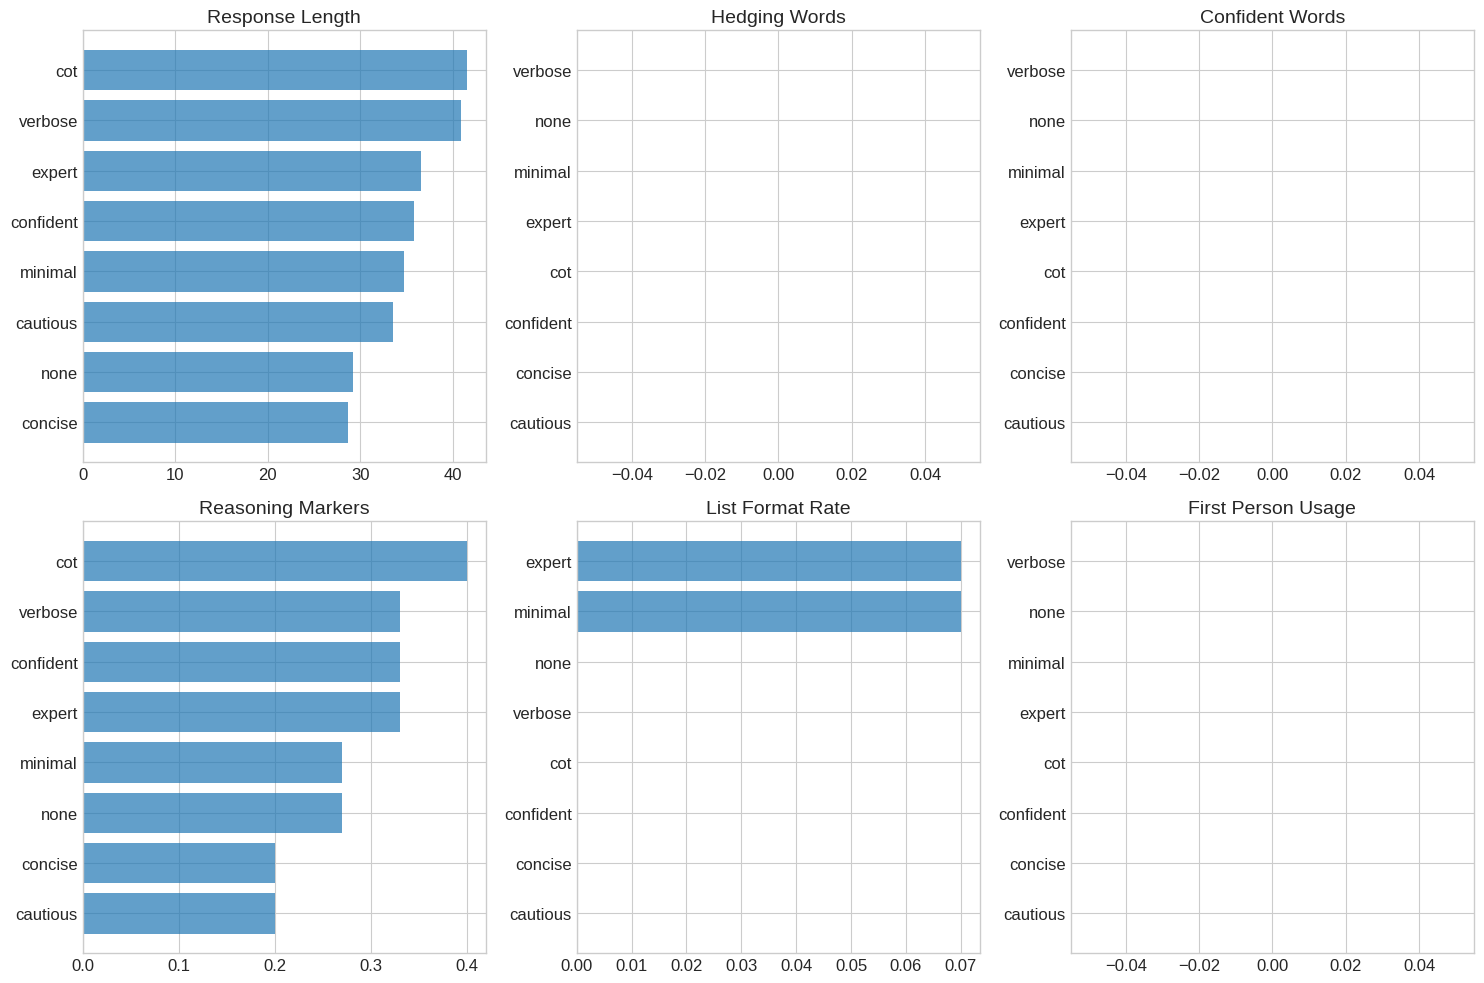

In [13]:
import os
os.makedirs('../results', exist_ok=True)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

metrics = ['length_words', 'hedging_count', 'confident_count', 
           'reasoning_count', 'has_list', 'first_person']
titles = ['Response Length', 'Hedging Words', 'Confident Words',
          'Reasoning Markers', 'List Format Rate', 'First Person Usage']

for ax, metric, title in zip(axes.flatten(), metrics, titles):
    data = pattern_summary[metric].sort_values()
    ax.barh(range(len(data)), data.values, alpha=0.7)
    ax.set_yticks(range(len(data)))
    ax.set_yticklabels(data.index)
    ax.set_title(title)

plt.tight_layout()
plt.savefig('../results/exp3_response_patterns.png', dpi=150)
plt.show()

## 4. Verify Expected Behaviors

In [14]:
print("=== Verification of Expected Behaviors ===")

# Concise should have shorter responses
concise_len = pattern_summary.loc['concise', 'length_words']
verbose_len = pattern_summary.loc['verbose', 'length_words']
print(f"\n1. Concise vs Verbose length: {concise_len:.1f} vs {verbose_len:.1f} words")
print(f"   → {'✓ Working' if concise_len < verbose_len else '✗ Not working'}")

# Cautious should have more hedging
cautious_hedge = pattern_summary.loc['cautious', 'hedging_count']
confident_hedge = pattern_summary.loc['confident', 'hedging_count']
print(f"\n2. Cautious vs Confident hedging: {cautious_hedge:.2f} vs {confident_hedge:.2f}")
print(f"   → {'✓ Working' if cautious_hedge > confident_hedge else '✗ Not working'}")

# CoT should have more reasoning markers
cot_reasoning = pattern_summary.loc['cot', 'reasoning_count']
none_reasoning = pattern_summary.loc['none', 'reasoning_count']
print(f"\n3. CoT vs None reasoning markers: {cot_reasoning:.2f} vs {none_reasoning:.2f}")
print(f"   → {'✓ Working' if cot_reasoning > none_reasoning else '✗ Not working'}")

=== Verification of Expected Behaviors ===

1. Concise vs Verbose length: 28.7 vs 40.9 words
   → ✓ Working

2. Cautious vs Confident hedging: 0.00 vs 0.00
   → ✗ Not working

3. CoT vs None reasoning markers: 0.40 vs 0.27
   → ✓ Working


## 5. Sample Responses Comparison

In [15]:
# Show sample responses for same prompt under different system prompts
sample_test = TEST_SUBSET[0]

print(f"Test Prompt: {sample_test['prompt']}\n")
print("="*60)

for sys_name in ['none', 'concise', 'verbose', 'cot']:
    response = responses_df[
        (responses_df['test_id'] == sample_test['id']) & 
        (responses_df['system_prompt'] == sys_name)
    ]['response'].values[0]
    
    print(f"\n[{sys_name.upper()}]")
    print(response[:300] + "..." if len(response) > 300 else response)
    print("-"*40)

Test Prompt: What is the capital of France?


[NONE]
The capital of France is Paris.
----------------------------------------

[CONCISE]
The capital of France is Paris.
----------------------------------------

[VERBOSE]
The capital of France is Paris.
----------------------------------------

[COT]
The capital of France is Paris.
----------------------------------------


In [16]:
# Save
import json
with open('../results/exp3_results.json', 'w') as f:
    json.dump({"pattern_summary": pattern_summary.to_dict()}, f, indent=2, default=float)
print("Saved.")

Saved.
